In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd
import math
import time
import statistics
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
tf.config.run_functions_eagerly(True)
size=200
filterSilence=True
#Run with or without tensorflow_probability
TFTSIM = False
"""
TODO:
Could select only real data with events. Done
Import my save.txt routine to optionally write output.
Rename the To TC with rate constants K13 K12 K23 etc.
Would another state help? I don't think so... 4 states should capture realistic bursting.
Could draw the transition matrix as a graph too? Too fancy. User can do this.
Noise could be more authentic still. 
a. Some slow-wave. freq, phase, amp.
b. Some open channel noise. tf.boolean_mask ...if open add white noise? could be slow.
c. replace noise with Sam noise? was it all TF?
d. SPIKE GENERATION SHOULD BE CHANGED, max should be x not abs(x) and number should be abs(x) not be abs(x) +1. X
e. pink noise should also be tf.function decorated!! X
f. WE ARE USING PROBABILITIES NOT RATES SO NEED TO ADAPT OR CORRECT BEFORE WRITING TO FILE!

F:: concerned about whether I have consistent use of dt.  In some places it seems with have an array that is T long. In other places this is called 
size and sometimes steps are 1 long and others they are df long @@
OK ...looks like the only time dt is used is when plotting simulated output.

CHANNEL IS LANE 0
RAW IS LANE 1

RUNNING ON MBP metal_101 env (102 doesn't work!). TF version 2.16 I believe. 
pip install tensorflow-macos tensorflow-metal
NB:
This version irrationally markovian simulates two channels but only ever uses the first 

"""
import os
import logging

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # '0' = all logs, '1' = filter out INFO logs, '2' = filter out WARNING logs, '3' = filter out ERROR logs

# Suppress other warnings
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Additional suppression for TensorFlow 2.x
tf.get_logger().setLevel('ERROR')

"""claude suggested this can improve performance
tf.keras.mixed_precision.set_global_policy('mixed_float16')"""

# List all physical GPUs
gpus = tf.config.list_physical_devices('GPU')

print(f"Number of GPUs detected: {len(gpus)}")


Number of GPUs detected: 1


In [2]:
n = 1  # Number of channels
dt = tf.constant(0.1, dtype=tf.float32)
T = tf.constant(size, dtype=tf.int32)  # In sample points :-)
#Must be a multiple of 2!!!
#Size of channel (relative to the channels so one channel
batch_size=10

In [3]:
@tf.function(experimental_compile=True)
def tf_relaxation(binary_sequence, half_life=4.0, relaxation_amount=0.2):
    """
    Apply exponential relaxation to a 1D binary sequence using vectorized TensorFlow operations.
    Kind of works backward to what you might think.  Where amp i1 1 and relaxation 0f 0.5 is too 0.5 therefore
    relaxation -0.5 is 0 to 1 but it then slowly rising to 1.5
    Args:
    binary_sequence: tf.Tensor, shape [time_steps], sequence of 0s and 1s
    half_life: float, the half-life of the exponential decay
    relaxation_amount: float, the amount of relaxation (positive or negative)
    Kind of works backward to what you might think.  Where amp i1 1 and relaxation 0f 0.5 is too 0.5 therefore
    relaxation -0.5 is 0 to 1 but it then slowly rising to 1.5
    Returns:
    tf.Tensor, shape [time_steps]
    """
    # Convert input to float32
    binary_sequence = tf.cast(binary_sequence, tf.float32)
    
    # Calculate decay rate
    decay_rate = tf.math.log(2.0) / half_life
    
    # Find the indices where steps occur
    steps = tf.not_equal(binary_sequence[1:] - binary_sequence[:-1], 0)
    step_indices = tf.where(steps)[:, 0]
    
    # Calculate the time since each step
    time_steps = tf.range(tf.shape(binary_sequence)[0], dtype=tf.float32)
    time_since_step = time_steps[:, tf.newaxis] - tf.cast(step_indices, tf.float32)
    
    # Calculate the exponential decay for each step
    decay = tf.exp(-decay_rate * tf.maximum(time_since_step, 0.0))
    
    # Calculate the relaxation effect
    step_values = tf.gather(binary_sequence, step_indices + 1) - tf.gather(binary_sequence, step_indices)
    relaxation_effect = relaxation_amount * step_values * decay
    
    # Sum the effects of all steps
    total_relaxation = tf.reduce_sum(relaxation_effect, axis=1)
    
    # Add the relaxation to the original sequence
    relaxed_sequence = binary_sequence + total_relaxation
    
    return relaxed_sequence

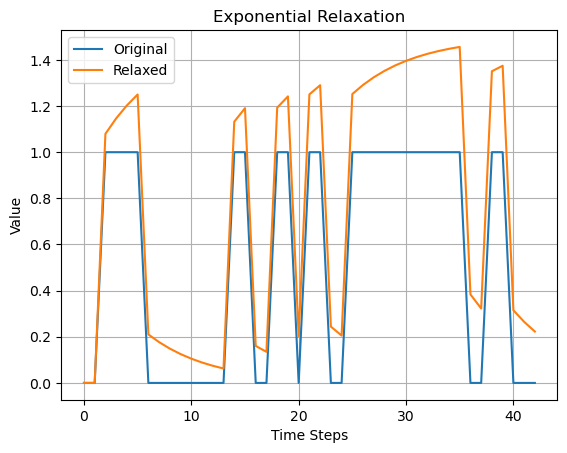

In [4]:
# Create a test sequence
test_sequence = tf.constant([0, 0, 1, 1, 1, 1, 0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,0,0,0], dtype=tf.float32)

# Apply the relaxation
relaxed_sequence = tf_relaxation(test_sequence, relaxation_amount=-0.5)

# Plot the results
plt.plot(test_sequence.numpy(), label='Original')
plt.plot(relaxed_sequence.numpy(), label='Relaxed')
plt.legend()
plt.title('Exponential Relaxation')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [5]:
"""
And entirely replaced function, by Claude now that doesn't use tf.probability
it seems. Is it really the same?
This needs to be checked. Certainly much faster this way. About 5x faster... it is getting 10% of the GPU cuda use now. was barely visible before.
"""

@tf.function(experimental_compile=True)
def normalize_row(row):
    # Find non-zero elements
    non_zero_mask = tf.not_equal(row, 0.0)
    non_zero_sum = tf.reduce_sum(tf.boolean_mask(row, non_zero_mask))
    
    # Normalize only non-zero elements
    normalized_row = tf.where(
        non_zero_mask,
        row / non_zero_sum,
        row
    )      
    return normalized_row

if not TFTSIM:
    @tf.function(experimental_compile=True)
    def sim_channel(params, n=1):
        #This is about twice the speed!
        """only handles n = 1, 2 or 3"""
        pc12, pc21, relaxation, Fnoise, scale, offset, relaxT, pco1, poc2, po12, po21 = params
        zero = tf.constant(0.0, dtype=tf.float32)
    
        # Markov chain simulation
        
        row1 = tf.stack([1-pc12, pc12, zero, zero])
        row2 = tf.stack([pc21, 1-pc21-pco1, pco1, zero])
        row3 = tf.stack([zero, poc2, 1-poc2-po12, po12])
        row4 = tf.stack([zero, zero, po21, 1-po21])
        
        unnormalized_matrix = tf.stack([row1, row2, row3, row4])

        # Normalize each row while preserving zero probabilities
        transition_matrix = tf.map_fn(normalize_row, unnormalized_matrix)
    
        initial_distribution = tfp.distributions.Categorical(probs=[0.3, 0.3, 0.2, 0.2])
     
        # Initial state distribution
        initial_probs = tf.constant([0.3, 0.3, 0.2, 0.2])
        
        # Manual Markov chain simulation
        tf.random.set_seed(int(time.time() * 1000) % (2**31 - 1))
        def body(i, state, channels):
            next_state_probs = tf.gather(transition_matrix, state)
            next_state = tf.random.categorical(tf.math.log([next_state_probs]), num_samples=1)[0, 0]
            if n == 3:
                # If n > 2 and next_state is 3, keep channels as they are but cast to float32
                channels = channels.write(i, tf.cast(next_state, tf.float32))
            elif n == 2:
                # If n == 2 and next_state is 2 or 3, set channels to 2
                channels = channels.write(i, tf.cast(tf.where(tf.greater_equal(next_state, 2), 2, next_state), tf.float32))
            elif n==1:
                channels = channels.write(i, tf.cast(tf.greater_equal(next_state, 2), tf.float32))
            else:
                print("SIM ERROR: 2342")
            return i+1, next_state, channels
    
        initial_state = tf.random.categorical(tf.math.log([initial_probs]), num_samples=1)[0, 0]
        channels = tf.TensorArray(tf.float32, size= (2 * T) )
        _, _, channels = tf.while_loop(
            lambda i, *_: i < (2*T),
            body,
            (0, initial_state, channels)
        )
        
        channels = channels.stack()
        channels = tf.squeeze(channels)
    
        # Generate pink noise
        white_noise = tf.random.normal(shape=[(2*T)])
        fft_len = (2*T) // 2 + 1
        f = tf.range(1, fft_len, dtype=tf.float32)
        spectrum = 1.0 / tf.sqrt(f)
        spectrum = tf.concat([tf.constant([1.0]), spectrum], axis=0)
        white_noise_fft = tf.signal.rfft(white_noise)
        pink_noise_fft = white_noise_fft * tf.cast(spectrum, tf.complex64)
        pink_noise = tf.signal.irfft(pink_noise_fft)
        pink_noise -= tf.reduce_mean(pink_noise)
        pink_noise = pink_noise / tf.math.reduce_std(pink_noise)
        noise = pink_noise * Fnoise
    
        # Add relaxation
        modified_raw_column = (channels * scale) + offset
        modified_raw_column = tf_relaxation(modified_raw_column, half_life=relaxT, relaxation_amount=relaxation)
        
        modified_raw_column += noise
    
        # Combine channels and modified raw column
        image = tf.stack([channels, modified_raw_column], axis=1)
        
        # Final safeguard against NaN values
        image = tf.where(tf.math.is_nan(image), tf.zeros_like(image), image)
        
        return image

In [6]:
if TFTSIM:
    #This is only going to work properly with n = 1 and it's slow.
    @tf.function(experimental_compile=True)
    def sim_channel(params, num_steps=T):
        pc12, pc21, relaxation, Fnoise, scale, offset, relaxT, pco1, poc2, po12, po21 = params
        zero = tf.constant(0.0, dtype=tf.float32)
        
        unnormalized_matrix = tf.stack([
             #s0     #s1  #s2   #s3
            [1-pc12, pc12, zero,   zero],          # state 0 CLOSED
            [pc21, 1-pc21-pco1, pco1, zero],   # state 1 CLOSED
            [zero, poc2, 1-poc2-po12, po12],   # state 2 OPEN
            [zero,    zero,   po21, 1-po21]        # state 3 OPEN
        ])
        
        # Normalize each row while preserving zero probabilities
        transition_matrix = tf.map_fn(normalize_row, unnormalized_matrix)
    
        initial_distribution = tfp.distributions.Categorical(probs=[0.3, 0.3, 0.2, 0.2])
        
        markov_chain = tfp.distributions.MarkovChain(
            initial_state_prior=initial_distribution,
            transition_fn=lambda _, state: tfp.distributions.Categorical(probs=tf.gather(transition_matrix, state)),
            num_steps=num_steps
        )
        states = markov_chain.sample()
        #Assuming we have one channel so emission is...
        emissions = tf.where(tf.less(states, 2), tf.zeros_like(states), tf.ones_like(states))
    
        channels = tf.cast(emissions, dtype=tf.float32)
        # Generate pink noise
        """
        white_noise = tf.random.normal(shape=[(2*T)])
        fft_len = (2*T) // 2 + 1
        f = tf.range(1, fft_len, dtype=tf.float32)
        spectrum = 1.0 / tf.sqrt(f)
        spectrum = tf.concat([tf.constant([1.0]), spectrum], axis=0)
        white_noise_fft = tf.signal.rfft(white_noise)
        pink_noise_fft = white_noise_fft * tf.cast(spectrum, tf.complex64)
        pink_noise = tf.signal.irfft(pink_noise_fft)
        pink_noise -= tf.reduce_mean(pink_noise)
        pink_noise = pink_noise / tf.math.reduce_std(pink_noise)
        noise = pink_noise * Fnoise
    
        # Add relaxation
        modified_raw_column = (channels * scale) + offset
        modified_raw_column = tf_relaxation(modified_raw_column, half_life=relaxT, relaxation_amount=relaxation)
        
        modified_raw_column += noise"""
        modified_raw_column = channels
        # Combine channels and modified raw column
        image = tf.stack([channels, modified_raw_column], axis=1)
        
        # Final safeguard against NaN values
        image = tf.where(tf.math.is_nan(image), tf.zeros_like(image), image)
        
        return image



In [7]:
# Parameters for the exponential distribution
num_samples = 1000
saveSim=False
"""pc12, pc21, relaxation, Fnoise, scale, offset, relaxT, pco1, poc2, po12, po21"""
pc12 = tf.constant(.3, dtype=tf.float32)  # Decreased from 0.1
pc21 = tf.constant(.8, dtype=tf.float32)  # Decreased from 0.1
pco1 = tf.constant(0.3, dtype=tf.float32)  # Decreased from 0.01
poc2 = tf.constant(1e-1, dtype=tf.float32)  # Decreased from 0.0001
po12 = tf.constant(0.8, dtype=tf.float32)  # Decreased from 0.01
po21 = tf.constant(1e-1, dtype=tf.float32)


relaxation = tf.constant(0.5, dtype=tf.float32)
Fnoise = tf.constant(.04, dtype=tf.float32)
SCALE = tf.constant(.6, dtype=tf.float32)
#And an offset
OFFSET = tf.constant(-0.4, dtype=tf.float32)
relaxT=25
# nE = tf.constant(200, dtype=tf.int32) #number of events


# Generate training data
fake_data = []
lens=[]
saver=[]
"""Actually replace "Anoise" with relaxation later"""
"""
for sample in tqdm(range(num_samples)):   
    params = tf.stack([pc12, pc21, relaxation, Fnoise, SCALE, OFFSET, relaxT, pco1, poc2, po12, po21])  # Use tf.stack instead of tf.constant
    segment = sim_channel(params, n=n)
    lens.append(sum(abs(segment)))
    fake_data.append(segment
    if saveSim:
        saver.extend(segment)  """

# Initialize A as a TensorArray
fake_data = tf.TensorArray(tf.float32, size=num_samples, dynamic_size=False, clear_after_read=False)
lens = []

for sample in tqdm(range(num_samples)):   
    params = tf.stack([pc12, pc21, relaxation, Fnoise, SCALE, OFFSET, relaxT, pco1, poc2, po12, po21])
    segment = sim_channel(params, n=n)
    lens.append(tf.reduce_sum(tf.abs(segment)))
    fake_data = fake_data.write(sample, segment)

# After the loop, stack A into a single tensor
fake_data = fake_data.stack()

# Convert lens to a tensor if needed
lens = tf.convert_to_tensor(lens)

print(f"Average duration was {sum(lens)/len(lens)}")
if saveSim:
    time_col = np.arange(0, len(saver) * dt, dt)
    np_data = np.column_stack((time_col, np.asarray(saver) ))

    # Convert to a pandas DataFrame
    df = pd.DataFrame(np_data, columns=['Time', 
                                              'Channels', 
                                              'Noisy Current'])
    df.to_csv("regularSimv10MBP.csv", index=False)

100%|███████████████████████████████████████| 1000/1000 [33:13<00:00,  1.99s/it]


Average duration was 438.10443115234375


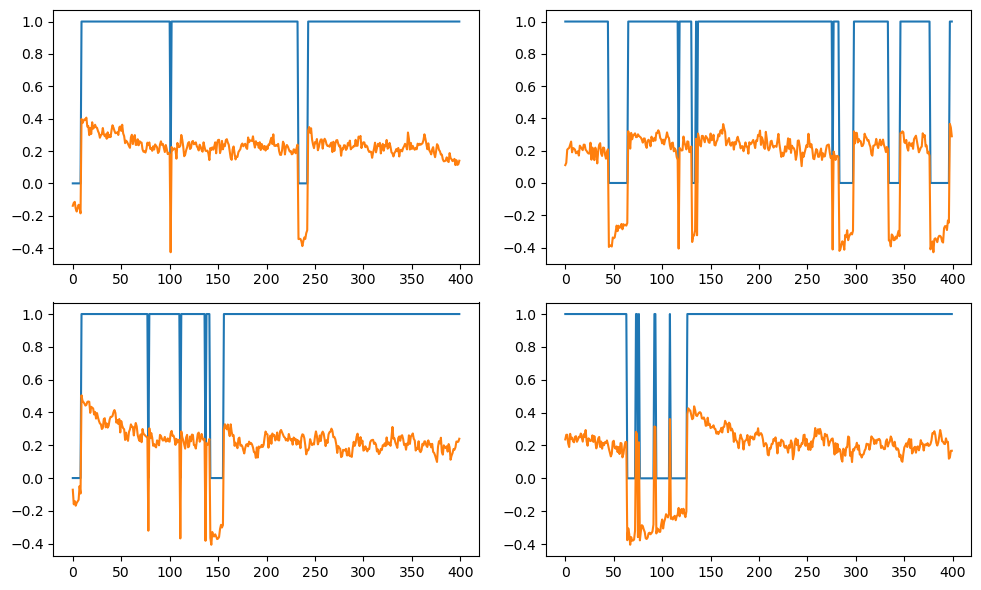

In [8]:
def plotter(data):
    # Create a figure with two subplots (panels)
    fig, axs = plt.subplots(2, 2, figsize=(10, 6))
     # Flatten the axs array for easy iteration
    axs = axs.flatten()
    
    for i in range(4):
        axs[i].plot(data[i])
        #axs[i].set_ylim([-200, 200])
    plt.tight_layout()
    plt.show()

plotter(fake_data)

In [9]:
def create_dataset(fake_data, batch_size):
    # Convert your fake_data to a tf.data.Dataset
    dataset = tf.data.Dataset.from_tensor_slices(fake_data)
    
    # Shuffle the entire dataset
    dataset = dataset.shuffle(buffer_size=len(fake_data))
    
    # Create batches of the specified size
    dataset = dataset.batch(batch_size)
    
    # Prefetch for better performance
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

dataset = create_dataset(fake_data, batch_size)


In [10]:
@tf.function(experimental_compile=True)
def get_random_batch(dataset, batch_size):
    # Shuffle the entire dataset
    shuffled_dataset = dataset.shuffle(buffer_size=1000)
    
    # Take one element (which is already a batch)
    batch = shuffled_dataset.take(1)
    
    # Convert the batch to a tensor
    tensor_batch = next(iter(batch))
    
    # If the requested batch_size is different from the pre-batched size,
    # we need to reshape
    if tensor_batch.shape[0] != batch_size:
        # Flatten the batch dimension
        flattened = tf.reshape(tensor_batch, [-1, 400, 2])
        # Take the requested number of examples
        return flattened[:batch_size]
    else:
        return tensor_batch



In [11]:
@tf.function(experimental_compile=True)
def prob_to_rate(params, delta_t):
    if len(params) == 11:
        pc12, pc21, _, _, _, _, _, pco1, poc2, po12, po21 = params
    else:
        pc12, pc21,pco1, poc2, po12, po21 = params
        
    zero = tf.constant(0.0, dtype=tf.float32)
    
    P = tf.stack([
        [1-pc12, pc12, zero, zero],
        [pc21, 1-pc21-pco1, pco1, zero],
        [zero, poc2, 1-poc2-po12, po12],
        [zero, zero, po21, 1-po21]
    ])
    
    # Convert probability matrix to rate matrix
    Q = (P - tf.eye(tf.shape(P)[0])) / delta_t
    
    return Q
    
@tf.function(experimental_compile=True)
def append_rates_to_csv(Q, filename='resultsv10MBP.csv'):
    param_names = ["_", "kc12", "zero", "zero", 
                   "kc21", "_", "kco1", "zero", 
                   "zero", "koc2", "_", "ko12", 
                   "zero", "zero", "ko21", "_"]
    
    # Flatten the rate matrix
    flat_rates = tf.reshape(Q, [-1])
    
    # Convert to string with comma separation
    row_string = tf.strings.join([tf.strings.as_string(rate) for rate in flat_rates], separator=",")
    
    # Add newline character
    row_string = tf.strings.join([row_string, tf.constant("\n")])
    
    # Check if file exists
    file_exists = tf.io.gfile.exists(filename)
    
    if file_exists:
        file_content = tf.io.read_file(filename)
        updated_content = tf.strings.join([file_content, row_string])
    else:
        header = tf.strings.join(param_names, separator=",")
        header = tf.strings.join([header, tf.constant("\n")])
        updated_content = tf.strings.join([header, row_string])
    
    # Write the updated content to file
    tf.io.write_file(filename, updated_content)


In [12]:
#Create REAL Trainging Data
file_path = "Lina2/4096lina11raw.csv"
df = pd.read_csv(file_path, header=None, names=["Raw", "Channels"])
df = df[["Channels","Raw"]]
# now crop to just one phenotype. There seem multiple in this dataset.
df=df[:75000]
#df=df[:12000]
df = pd.concat([df] * 1, ignore_index=True)
noise = np.random.normal(0, 0.01, df["Raw"].shape)
df["Raw"] += noise
num_rows = (len(df) // (2*size)) * size*2
print(num_rows)
df = df.iloc[:num_rows]
data_array = df.to_numpy()
data_tensor = tf.convert_to_tensor(data_array, dtype=tf.float32)
training_data = tf.reshape(data_tensor, [-1, size*2, 2])
#Calculate real num_samples!
num_samples= tf.shape(training_data)[0]
#num_samples = 10 #debug
#Only use windows where something happened!
filterSilence = False
if filterSilence:
    first_column = training_data[:, :, 0]
    all_same = tf.reduce_all(tf.equal(first_column, first_column[:, 0:1]), axis=1)
    
    # Filter out batches where all values in the first column are the same
    training_data = tf.boolean_mask(training_data, ~all_same)



74800


<Axes: >

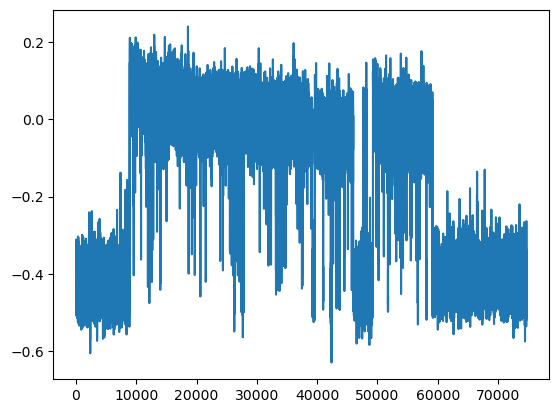

In [13]:
df["Raw"].plot()

In [14]:
# Define the generator model
"""pc12, pc21, relaxation, Fnoise, SCALE, OFFSET, relaxT, pco1, poc2, po12, po21"""
gen_input_len=size*2

def make_generator_model():
    """batch normalisation is terrible!!"""
    noise_input = tf.keras.layers.Input(shape=(gen_input_len,))
    x = tf.keras.layers.Dense(128)(noise_input)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.ReLU()(x)
    
    # Output layer without activation
    output = tf.keras.layers.Dense(gen_input_len)(x)
    
    return tf.keras.Model(inputs=noise_input, outputs=output)

# Define the discriminator model batch, record len, channels = events then noise
#num_points = T.numpy().item()
def make_discriminator_model():
    input_shape = (2*size,2) 
    inputs = tf.keras.Input(shape=input_shape)

    # Reshape input to add channel dimension
    x = tf.keras.layers.Reshape((size*2, 2))(inputs)
    
    # 1D Convolutional layers
    x = tf.keras.layers.Conv1D(8, kernel_size=5, strides=2, padding='same', activation='leaky_relu')(x)
    x = tf.keras.layers.Conv1D(16, kernel_size=5, strides=2, padding='same', activation='leaky_relu')(x)
    x = tf.keras.layers.Conv1D(32, kernel_size=5, strides=2, padding='same', activation='leaky_relu')(x)
    x = tf.keras.layers.Dropout(0.3) (x)
    
    # Global average pooling
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(1)(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)


# Loss functions and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

@tf.function(experimental_compile=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss
    
@tf.function(experimental_compile=True)
def generator_loss(fake_output):
    return tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output, from_logits=True))

generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)


In [15]:
# Training step
@tf.function(experimental_compile=True)
def train_step(real_data):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        f_data = get_random_batch(dataset, batch_size)
        generated_noise = generator(f_data[:,:,0:1], training=True)

        generated_noise = tf.expand_dims(generated_noise, axis=-1) 
        noised = tf.concat([f_data[:,:,0:1] , f_data[:,:,1:2] + generated_noise ], axis=-1)

        real_output = discriminator(real_data, training=True)
        fake_output = discriminator(noised, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)       
        gen_loss  = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    # return gen_loss, disc_loss, gan_loss, reg_loss
    index = tf.cast(tf.random.uniform([], 0, batch_size , dtype=tf.float32), tf.int32)
    return gen_loss, disc_loss, noised[index,100:300,:]

# Training loop
@tf.function(experimental_compile=True)
def train(dataset, epochs):
    steps_per_epoch = math.floor(num_samples / batch_size)
    #steps_per_epoch = 2
    tf.print("steps per epoch", steps_per_epoch)
    for epoch in range(getREALepoch(),epochs,1):
        #print(f"Epoch {epoch + 1}/{epochs}")
        read_set_lr()
        # Initialize loss accumulators for each epoch
        epoch_gen_loss = 0
        epoch_disc_loss = 0
        #for step, batch in tqdm(enumerate(dataset.take(steps_per_epoch)), total=steps_per_epoch, ncols=60):
        for step, batch in enumerate(dataset.take(steps_per_epoch)):    
            #clear_output(wait=True)
            if step >= steps_per_epoch:
                break  # Move to the next epoch          
            try:
                gen_loss, disc_loss, record = train_step(batch)
                #tf.print("gen_loss",gen_loss)
                epoch_gen_loss += gen_loss
                #tf.print("epoch_gen_loss",gen_loss)
                epoch_disc_loss += disc_loss
            except Exception as e:
                print(f"Error during training: {e}")
                break

        #tf.print("epoch_gen_loss",epoch_gen_loss)
        # Calculate average losses for the epoch
        avg_gen_loss = epoch_gen_loss / steps_per_epoch
        avg_disc_loss = epoch_disc_loss / steps_per_epoch
        if (epoch + 1) % 10 == 0:
            clear_output(wait=True)
            tf.print(f"Epoch {epoch + 1}/{epochs} - "
                  f"Generator Loss: {avg_gen_loss:.8f}, "
                  f"Discriminator Loss: {avg_disc_loss:.8f}")
            checkpoint.save(file_prefix = 'markovCheckpoints/checkpoint')
            random_index2 = tf.random.uniform(shape=[], minval=0, maxval=tf.shape(training_data)[0], dtype=tf.int32)
            biPlotter([record,training_data[random_index2]], 0, random_index2, epoch)

In [33]:
def biPlotter(data, n, m, epoch):
    # Create a figure with two subplots (panels)
    fig, axs = plt.subplots(2, 1, figsize=(10, 6))
    axs[0].plot(data[0] )
    axs[0].set_title(f"Generated Wave, record {n}, epoch {epoch}")
    axs[0].set_ylim([-1,1.2])
    axs[1].plot(data[1][100:300,:] )
    axs[1].set_title(f"Training Data, record {m}")
    axs[1].set_ylim([-1,1.2])
    plt.tight_layout()
    plt.savefig(f"chanFigs/fig{epoch}.png")
    plt.show()
    #time.sleep(1)

In [17]:
def writeMe(samples=10000, dt=dt, epoch=0, file="markovData/output.parquet"):
    sampleNoise = tf.random.normal([samples, gen_input_len])
    generated_params = generator(sampleNoise, training=False)
    gen_waves=[]
    for i in tqdm(range(samples)):
        gen_waves.extend( sim_channel(generated_params[i]) )
    df = pd.DataFrame(gen_waves, columns=["Channels", "Noisy Current"])
    df["Time"] = dt * pd.Series(range(len(df)))
    df = df[["Time", "Channels", "Noisy Current"]]
    df["Channels"] = df["Channels"].apply(lambda x: x.numpy().item())
    df["Noisy Current"] = df["Noisy Current"].apply(lambda x: x.numpy().item())
    df.to_parquet(f"{file}")
    print(f"Data saved to {file}")
    
    

In [18]:
def getREALepoch() -> int:
    import glob
    import os
    import re
    """
    Save the current image to the working directory of the program.
    """
    currentfiles = glob.glob("markovCheckpoints/*.index")
   
    numList = [0]
    for file in currentfiles:
        i = os.path.splitext(file)[0]
        try:
            pattern = r'-(\d+)'
            num = re.findall(pattern, i)[0]
            numList.append(int(num))
        except IndexError:
            pass
    numList = sorted(numList)
    return numList[-1]

In [19]:

"""training_dataset = tf.data.Dataset.from_tensor_slices(
    training_data).shuffle(5000).batch(batch_size, drop_remainder=True).repeat()"""
buffer_size = 5000  # Keeping your current shuffle buffer size
training_synth = tf.data.Dataset.from_tensor_slices(training_data)
training_dataset = tf.data.Dataset.from_tensor_slices(training_data)
training_dataset = (training_dataset
    .cache()  # Cache the dataset in memory
    .shuffle(buffer_size)
    .batch(batch_size, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)  # Prefetch next batch while current batch is being processed
    .repeat()  # Repeat the dataset indefinitely
)


In [21]:
@tf.function(experimental_compile=True)
def read_set_lr():
    with open("lr.txt", "r+") as my_file:
        data = my_file.read()
        split = data.split('\n')
        parse_lr_from_file = lambda string: float(string.split(":")[1])
        new_gen_lr = parse_lr_from_file(split[1])
        new_disc_lr = parse_lr_from_file(split[2])
        generator_optimizer.learning_rate.assign(tf.cast(new_gen_lr, generator_optimizer.learning_rate.dtype))
        discriminator_optimizer.learning_rate.assign(tf.cast(new_disc_lr, discriminator_optimizer.learning_rate.dtype))
        """tf.print(f"dLR: {discriminator_optimizer.learning_rate.value.numpy():.3e},\
                    gLR: {generator_optimizer.learning_rate.value.numpy():.3e}")"""

In [22]:
learning_rate_value = 1e-5

# Convert the learning rate value to the appropriate dtype
generator_optimizer.learning_rate.assign(tf.cast(learning_rate_value, generator_optimizer.learning_rate.dtype))
learning_rate_value = 1e-4
discriminator_optimizer.learning_rate.assign(tf.cast(learning_rate_value, discriminator_optimizer.learning_rate.dtype))

In [23]:
read_set_lr()
discriminator_optimizer.learning_rate.value
generator_optimizer.learning_rate.value

<tf.Variable 'adam/learning_rate:0' shape=() dtype=float32, numpy=1e-05>

In [24]:
checkpoint_dir = "markovCheckpoints/checkpoints"
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator)


Epoch 740/20000 - Generator Loss: 1.18419075, Discriminator Loss: 0.84757507


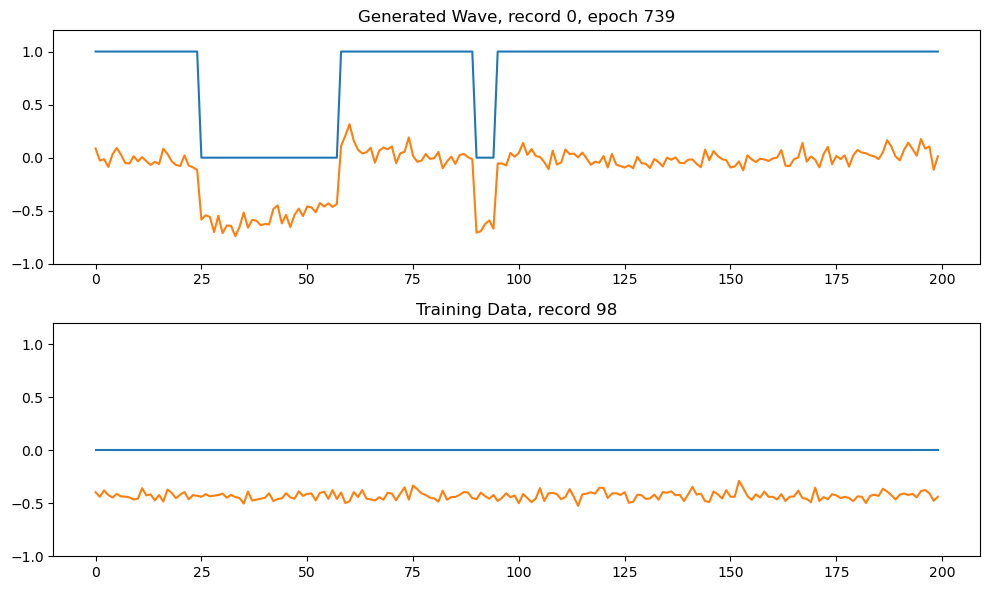

In [ ]:
writeNow=False
epochs=20000 
train(training_dataset, epochs)

In [ ]:
checkpoint.restore('markovCheckpoints/checkpoint-184').assert_existing_objects_matched()
